# Figure 5- V2 animals are more motivated


In [149]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, friedmanchisquare, wilcoxon
import statsmodels.formula.api as smf
import itertools

sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Load


In [2]:
pdf = u.load_poke_df()

Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


# Utility Function


In [58]:
"""Statistical Functions"""
def check_normality(data, alpha=0.05):
    """
    Returns True if data passes the Shapiro–Wilk test for normality
    at the specified alpha level, False otherwise.
    """
    stat, p = shapiro(data)
    return p >= alpha

def compare_two_groups(v1_values, v2_values, alpha=0.05):
    """
    Given two arrays of values (V1 and V2), checks normality in each group.
    If both pass, runs Welch's t-test. Otherwise, runs Mann–Whitney U.
    Returns a dict with test results.
    """
    normal_v1 = check_normality(v1_values, alpha=alpha)
    normal_v2 = check_normality(v2_values, alpha=alpha)

    results = {
        "normality_V1": normal_v1,
        "normality_V2": normal_v2,
        "n_V1": len(v1_values),
        "n_V2": len(v2_values),
    }

    if normal_v1 and normal_v2:
        # Use Welch’s t-test (two-sample, unequal variance)
        stat, p_val = ttest_ind(v1_values, v2_values, equal_var=False)
        results["test_type"] = "welch_t"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val
    else:
        # Use Mann–Whitney U for non-normal data
        stat, p_val = mannwhitneyu(v1_values, v2_values, alternative="two-sided")
        results["test_type"] = "mannwhitney"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val

    return results

def compare_v1_v2(df, metric_col, alpha=0.05):
    """
    Compare experimental groups V1 and V2 for data in a single stage.
    Assumes that the DataFrame `df` contains data for only one stage.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            'fix_experiment' (with values 'V1' or 'V2')
            and the specified metric_col (the numeric variable to compare).
    metric_col : str
        The numeric variable to compare.
    alpha : float, optional
        Significance level for normality tests and final threshold (default 0.05).

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with a single row summarizing the test results.
    """
    # Extract data for V1 and V2
    v1_data = df.loc[df["fix_experiment"] == "V1", metric_col].to_numpy()
    v2_data = df.loc[df["fix_experiment"] == "V2", metric_col].to_numpy()

    # Compare the two groups
    result = compare_two_groups(v1_data, v2_data, alpha=alpha)
    
    # Return the result as a DataFrame with one row.
    result_df = pd.DataFrame([result])
    return result_df

def compare_v1_v2_multi_sample(df, metric_col, alpha=0.05):
    """
    Fit a mixed effects model to compare V1 and V2 for data in a single stage.
    Assumes that the DataFrame `df` contains data for only one stage.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            'animal_id', 'fix_experiment' (with values 'V1' or 'V2'),
            and the specified metric_col (the numeric variable to compare).
    metric_col : str
        The numeric variable to compare.
    alpha : float, optional
        Significance level for the normality check of residuals (default 0.05).

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with a single row summarizing the mixed model test results.
    """
    required_cols = ["animal_id", "fix_experiment", metric_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"DataFrame is missing required column: '{col}'")

    # Ensure both groups exist in the data
    v1_df = df[df["fix_experiment"] == "V1"]
    v2_df = df[df["fix_experiment"] == "V2"]
    if v1_df.empty or v2_df.empty:
        raise ValueError("Both experimental groups (V1 and V2) must be present in the data.")

    # Fit the mixed effects model: metric_col ~ fix_experiment with a random intercept for animal_id
    model = smf.mixedlm(formula=f"{metric_col} ~ fix_experiment",
                        data=df,
                        groups=df["animal_id"])
    try:
        model_fit = model.fit(method="lbfgs", disp=False)
    except Exception as e:
        raise RuntimeError(f"Model fitting failed with error: {e}")

    coef_key = "fix_experiment[T.V2]"
    if coef_key not in model_fit.params.index:
        raise ValueError("Coefficient for fix_experiment[T.V2] not found in model fit.")

    t_val = model_fit.tvalues[coef_key]
    p_val = model_fit.pvalues[coef_key]

    # Check normality of the residuals from the model
    residuals = model_fit.resid
    residuals_are_normal = check_normality(residuals, alpha=alpha)

    result = {
        "test_type": "mixedlm_random_intercept",
        "test_statistic": t_val,
        "p_val_raw": p_val,
        "residuals_normal": residuals_are_normal,
    }
    result_df = pd.DataFrame([result])
    return result_df

# A- Growth Stage (5-7) Violation Rates


In [77]:
plot_df = pdf.query("stage > 4 and stage < 8").groupby(["animal_id", "fix_experiment", "date"]).agg({"was_valid": "mean"}).reset_index()
plot_df["violation_rate"] = 1 - plot_df["was_valid"]


In [76]:
plot_df.groupby(["animal_id", "fix_experiment", "date"]) \
    .agg(mean_violation_rate=("violation_rate", "mean")) \
    .reset_index() \
    .groupby(["fix_experiment"]) \
    .agg(mean_violation_rate=("mean_violation_rate", "mean"),
         std_violation_rate=("mean_violation_rate", "std"),
         n_sessions=("mean_violation_rate", "count")).reset_index()

,fix_experiment,mean_violation_rate,std_violation_rate,n_sessions
0,V1,0.218157,0.116306,237
1,V2,0.461378,0.164299,110


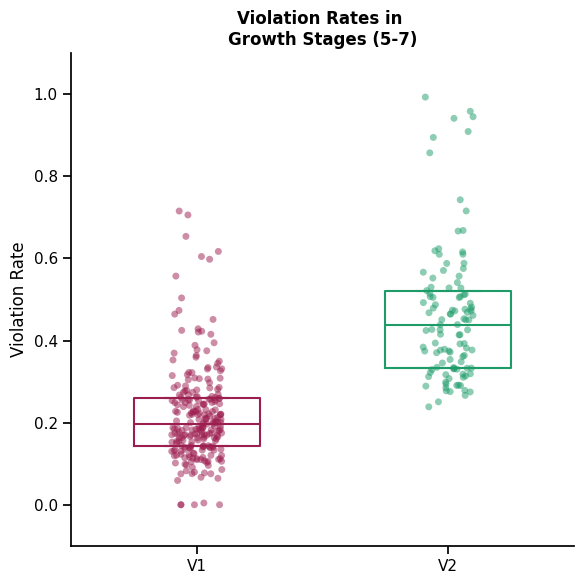

In [66]:
fig, ax = plt.subplots(figsize=(6,6))
x = "fix_experiment"
y="violation_rate"
order=c.HUE_ORDER_EXP
hue_type="experiment"

sns.despine()

sns.boxplot(
    x=x,
    y=y,
    data=plot_df,
    order=order,
    ax=ax,
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    palette=c.EXP_PALETTE,
    fill=False,
    showfliers=False,
    whis=False,
    width=0.5,
)

if hue_type == "animal":
    hue = "animal_id"
    hue_order = c.HUE_ORDER_ANIMALS
    palette = c.ANIMAL_PALETTE
else:
    hue = "fix_experiment"
    hue_order = ["V1", "V2"]
    palette = c.EXP_PALETTE

sns.stripplot(
    x=x,
    y=y,
    data=plot_df,
    order=order,
    ax=ax,
    hue=hue,
    hue_order=hue_order,
    palette=palette,
    dodge=False,
    legend=False,
    alpha=0.5,
)
ax.set(
    ylabel="Violation Rate",
    ylim=(-0.1, 1.1),
    xlabel="",
)

ax.set_title("Violation Rates in \nGrowth Stages (5-7)", fontweight="bold")


plt.tight_layout()

#save fig
fig.savefig("figures/V0_fig4a_growth_violation_rates.png", dpi=300, bbox_inches="tight")



In [ ]:

compare_v1_v2(plot_df, "violation_rate")
 

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,237,110,mannwhitney,1977.5,4.787234e-37


In [63]:
compare_v1_v2_multi_sample(plot_df, "violation_rate")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,7.344254,2.069095e-13,False


# F- V2 Transition To Penalty On


In [103]:
plot_df = u.compute_days_relative_to_stage(pdf.query("fix_experiment == 'V2'").copy(), stage=8)
plot_df = plot_df[~((plot_df['settling_violation'] == 1) & (plot_df['days_relative_to_stage_8'] >= 0))] # remove settling in violations since they are not a true violation once in stage 8

plot_df = plot_df.query("days_relative_to_stage_8 >=-1 and days_relative_to_stage_8 <= 1") \
    .groupby(["animal_id", "fix_experiment", "days_relative_to_stage_8", "stage"]).agg({"was_valid": "mean"}).reset_index()
plot_df["violation_rate"] = 1 - plot_df["was_valid"]
plot_df.head()

,animal_id,fix_experiment,days_relative_to_stage_8,stage,was_valid,violation_rate
0,R041,V2,-1,7.0,0.488491,0.511509
1,R041,V2,0,8.0,0.808036,0.191964
2,R041,V2,1,9.0,0.658163,0.341837
3,R043,V2,-1,7.0,0.618343,0.381657
4,R043,V2,0,8.0,0.841727,0.158273


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_13663/2190657718.py:6: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(


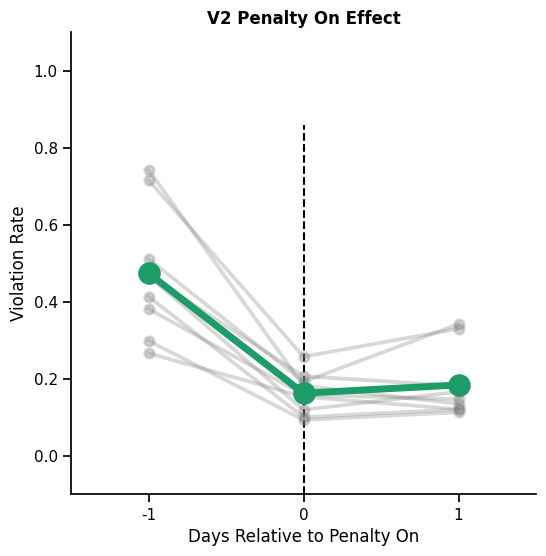

In [160]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()
day_range = [-1, 1]

ax.axvline(x=1, color="k", ls = "--", ymax=0.8)
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="violation_rate",
    hue="animal_id",
    palette=["gray"],
    ax=ax,
    alpha=0.3,
    legend=False
)
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="violation_rate",
    color=c.V2_COLOR,
    ax=ax,
    errorbar=None,
    linewidth=5,  # make the line thicker
)


ax.set(
    ylabel="Violation Rate",
    xlabel="Days Relative to Penalty On",
    ylim=(-0.1, 1.1),
)

ax.set_title("V2 Penalty On Effect", fontweight="bold")

fig.savefig("figures/V0_fig4e_v2_penalty_on.png", dpi=300, bbox_inches="tight")

In [162]:
plot_df.groupby(["days_relative_to_stage_8"]).agg(mean_violation_rate=("violation_rate", "mean"), std_violation_rate=("violation_rate", "std")).reset_index()

,days_relative_to_stage_8,mean_violation_rate,std_violation_rate
0,-1,0.474044,0.165135
1,0,0.162428,0.053464
2,1,0.183954,0.089001


In [150]:
df_wide = plot_df.pivot(index='animal_id', columns='days_relative_to_stage_8', values='violation_rate')

# Check the pivoted data (optional)
print(df_wide)

# Perform the Friedman test. Ensure you order the columns appropriately.
stat, p_value = friedmanchisquare(df_wide[-1], df_wide[0], df_wide[1])
print(f"Friedman test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Define the days to compare and perform pairwise Wilcoxon tests
days = [-1, 0, 1]
comparisons = list(itertools.combinations(days, 2))
alpha = 0.05
alpha_adjusted = alpha / len(comparisons)  # Bonferroni correction

for d1, d2 in comparisons:
    stat, p = wilcoxon(df_wide[d1], df_wide[d2])
    print(f"Comparison between day {d1} and day {d2}: Wilcoxon statistic = {stat:.4f}, p-value = {p:.4f} (adjusted α = {alpha_adjusted:.4f})")

days_relative_to_stage_8        -1         0         1
animal_id                                             
R041                      0.511509  0.191964  0.341837
R043                      0.381657  0.158273  0.146739
R045                      0.468560  0.206633  0.181572
R047                      0.298667  0.093023  0.112957
R049                      0.266402  0.153061  0.120968
R051                      0.413479  0.100223  0.120635
R053                      0.715655  0.257426  0.329897
R055                      0.742802  0.181818  0.134752
R057                      0.467669  0.119433  0.166227
Friedman test statistic: 13.5556
P-value: 0.0011
Comparison between day -1 and day 0: Wilcoxon statistic = 0.0000, p-value = 0.0039 (adjusted α = 0.0167)
Comparison between day -1 and day 1: Wilcoxon statistic = 0.0000, p-value = 0.0039 (adjusted α = 0.0167)
Comparison between day 0 and day 1: Wilcoxon statistic = 17.0000, p-value = 0.5703 (adjusted α = 0.0167)
